## Utah Snow-Water-Equivalent Modeling

#### Copyright Jason Martineau 2023, all rights reserved.

### 0.0 Introduction

#### This notebook contains a predictive analysis of Utah's snow water equivalent (SWE) measurements. The SWE is how much melt water that will be derived from a given amount of snow once it melts. I use timeseries datasets of SWE and cumulative precipitation to predict the SWE seven days in advance. The timeseries data sets are partitioned by sub-basins around the state of Utah. I use the data from all basins to predict the SWE within the cottonwood sub-basin, which is a basin on the Wasatch Front, near Salt Lake City. This same methodology could be applied to any sub-basin on interest around the state. 

#### I collected this data from the following website, https://www.nrcs.usda.gov/wps/portal/wcc/home/quicklinks/states/utah/snow/basinData/ . I manually downloaded .csv files for each basin. In what follows below, I begin by combining all of the data set.s

### 1.0 Data Import, Cleaning, Formatting

#### First I import the libraries that I will need for this analysis.

In [2]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import joblib
import numpy as np

# set max display columns and rows to a large number to facilitate initial exploration of data.
pd.options.display.max_rows = 1000;
pd.options.display.max_columns = 100;

2023-12-07 14:25:12.713715: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Here I define a dictionary to organize the different file paths to the directories with the data that I collected. I then read in each flat file and store it in its respective key.

In [3]:
paths = {
    "precip" : "./SWE-data/Precip-data",
    "soil" : "./SWE-data/Soil-Moisture-data",
    "swe" : "./SWE-data/SWE-data",
    "temp" : "./SWE-data/Temp-data"
}

data = {
    "precip" : {},
    "soil" : {},
    "swe" : {},
    "temp" : {}
}

for key in paths:
    geographic_locations = [f for f in listdir(paths[key]) if isfile(join(paths[key], f))]
    for location in geographic_locations:
        data[key].update({location.replace('.csv', '') : pd.read_csv(join(paths[key], location))});

### 1.1 Initial Examination of the Data

#### Now that the data are imported in an organized way I can make an initial examination of the data. The first key in the data dictionary is for the type of data, like SWE or precipitation. The second key is for a sub-basin. 

#### Below are a few examples of how the data are structured. The columns denote the year, or aggregate statistics, and the rows denote the month and day of the year. After I investigate how much of the data are usable, and now may missing values there are, I will reformat this into a more typical time-series format where all of the values are listed by datetime, sequentially. I will do this for each sub-basin and type of data. 

In [4]:
data["swe"]["mill_creek"].head(5)

,date,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,Min,10%,30%,70%,90%,Max,Median ('91-'20),Median (POR),Median Peak SWE
0,10-01,0.0,1.5,0.0,0.0,0.0,1.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,12.8
1,10-02,0.0,1.5,0.0,0.0,0.0,1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,12.8
2,10-03,0.0,1.5,0.0,0.0,0.0,1.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.6,0.0,0.0,12.8
3,10-04,0.0,1.5,0.0,0.0,0.0,1.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.6,0.0,0.0,12.8
4,10-05,0.0,1.5,0.0,0.0,0.0,1.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.6,0.0,0.0,12.8


In [5]:
data["precip"]["mill_creek"].head(5)

,date,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,Min,10%,30%,70%,90%,Max,Median ('91-'20),Median (POR)
0,10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10-02,0.0,0.0,0.3,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.7,0.0,0.0,0.1,0.0,0.0,0.0,0.5,0.0,0.0,0.1,0.5,0.0,0.0,0.0,0.1,0.2,0.0,0.0,0.0,0.0,0.5,0.7,0.0,0.0
2,10-03,0.3,0.0,1.0,0.7,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.6,1.3,0.0,0.0,0.0,0.0,0.6,0.3,0.0,0.2,0.0,0.7,0.0,0.0,0.1,0.0,0.0,0.0,0.5,0.0,0.1,0.2,1.4,0.0,0.0,0.1,0.4,0.4,0.0,0.0,0.0,0.2,0.7,1.4,0.0,0.0
3,10-04,0.6,0.0,1.0,1.3,0.0,0.9,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.1,0.1,0.6,1.3,0.3,0.0,0.0,0.0,0.7,0.5,0.0,0.2,1.7,0.7,0.0,0.0,0.7,0.1,0.0,0.5,0.5,0.0,0.2,0.2,1.4,0.0,0.0,0.2,0.4,0.4,0.0,0.0,0.0,0.5,1.0,1.7,0.1,0.2
4,10-05,0.9,0.0,1.0,1.5,0.0,0.9,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.2,0.1,0.9,1.3,0.3,0.0,0.0,0.0,0.8,0.6,0.0,0.2,1.7,0.7,1.2,0.1,1.1,0.7,0.0,0.6,0.5,0.2,0.2,0.2,2.0,0.0,0.0,0.3,0.4,0.4,0.0,0.0,0.0,0.7,1.2,2.0,0.2,0.2


In [6]:
data["soil"]["mill_creek"].head(5)

,date,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,Min,10%,30%,70%,90%,Max,Median (POR)
0,10-01,44.7,57.9,66.2,21.3,17.8,25.9,8.8,9.6,8.5,53.9,48.1,46.8,8.5,8.8,17.8,48.1,57.9,66.2,25.9
1,10-02,24.3,56.9,69.0,20.8,19.7,25.6,8.1,9.5,8.3,55.0,48.3,46.3,8.1,8.3,19.7,48.3,56.9,69.0,24.3
2,10-03,23.9,55.8,67.5,19.5,20.1,25.7,8.0,8.8,8.6,55.9,48.5,46.4,8.0,8.6,19.5,48.5,55.9,67.5,23.9
3,10-04,23.3,55.3,65.5,18.6,20.0,25.7,13.5,8.8,8.4,56.1,49.1,45.8,8.4,8.8,18.6,49.1,56.1,65.5,23.3
4,10-05,23.7,55.6,63.0,18.0,19.3,25.7,19.1,9.1,8.2,55.8,49.2,45.2,8.2,9.1,19.1,49.2,55.8,63.0,23.7


In [7]:
data["temp"]["mill_creek"].head(5)

,date,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,Min,10%,30%,70%,90%,Max,Median (POR)
0,10-01,51.8,51.5,36.6,61.0,47.1,44.2,49.6,48.3,53.7,40.6,46.9,47.5,36.6,40.6,46.9,51.5,53.7,61.0,48.3
1,10-02,52.0,51.4,36.5,51.0,49.9,31.5,49.4,43.4,52.9,43.1,45.6,40.5,31.5,36.5,43.4,51.0,52.0,52.9,49.4
2,10-03,53.6,40.6,42.2,45.5,39.2,44.6,52.3,52.3,52.6,43.9,42.7,37.5,39.2,40.6,42.7,52.3,52.6,53.6,44.6
3,10-04,53.3,26.6,44.4,50.0,35.6,52.5,45.7,49.3,52.7,46.8,43.7,39.4,26.6,35.6,44.4,50.0,52.7,53.3,46.8
4,10-05,48.0,31.7,46.0,43.4,39.1,52.5,41.0,43.2,53.2,47.2,45.0,44.2,31.7,39.1,43.2,47.2,52.5,53.2,45.0


### 1.1 Initial Formatting

#### I will continue with only SWE and precipitation data. This is because these data extand back 40 years, where as temperature and soil saturation have only been recorded since 2013. 

#### Next I will add the geographic location and the data type of each record. This will allow me to combine all of the data sets into one central data set.

In [8]:
for data_type in ["swe", "precip"]:
    for location_key in data[data_type]:
        data[data_type][location_key]["data_type"] = data_type;
        data[data_type][location_key]["geographic_location"] = location_key;
        
for location_key in data["swe"]:
    data["swe"][location_key].drop("Median Peak SWE", axis = 1, inplace = True)

In [9]:
data["precip"]["mill_creek"].head()

,date,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,Min,10%,30%,70%,90%,Max,Median ('91-'20),Median (POR),data_type,geographic_location
0,10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,precip,mill_creek
1,10-02,0.0,0.0,0.3,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.7,0.0,0.0,0.1,0.0,0.0,0.0,0.5,0.0,0.0,0.1,0.5,0.0,0.0,0.0,0.1,0.2,0.0,0.0,0.0,0.0,0.5,0.7,0.0,0.0,precip,mill_creek
2,10-03,0.3,0.0,1.0,0.7,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.6,1.3,0.0,0.0,0.0,0.0,0.6,0.3,0.0,0.2,0.0,0.7,0.0,0.0,0.1,0.0,0.0,0.0,0.5,0.0,0.1,0.2,1.4,0.0,0.0,0.1,0.4,0.4,0.0,0.0,0.0,0.2,0.7,1.4,0.0,0.0,precip,mill_creek
3,10-04,0.6,0.0,1.0,1.3,0.0,0.9,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.1,0.1,0.6,1.3,0.3,0.0,0.0,0.0,0.7,0.5,0.0,0.2,1.7,0.7,0.0,0.0,0.7,0.1,0.0,0.5,0.5,0.0,0.2,0.2,1.4,0.0,0.0,0.2,0.4,0.4,0.0,0.0,0.0,0.5,1.0,1.7,0.1,0.2,precip,mill_creek
4,10-05,0.9,0.0,1.0,1.5,0.0,0.9,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.2,0.1,0.9,1.3,0.3,0.0,0.0,0.0,0.8,0.6,0.0,0.2,1.7,0.7,1.2,0.1,1.1,0.7,0.0,0.6,0.5,0.2,0.2,0.2,2.0,0.0,0.0,0.3,0.4,0.4,0.0,0.0,0.0,0.7,1.2,2.0,0.2,0.2,precip,mill_creek


#### Now with the geographic location and data type included, I will concatenate the SWE and precipitation data together. df_full is this central data set.

In [10]:
df_full = pd.DataFrame()
for data_type in ["swe", "precip"]:
    for location_key in data[data_type]:
        df_full = pd.concat([df_full,data[data_type][location_key]], axis = 0, ignore_index = False)

In [11]:
df_full.head(5)

,date,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,Min,10%,30%,70%,90%,Max,Median (POR),data_type,geographic_location,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,Median ('91-'20),1981,1982,1983,1984,1985,1986,1987,1988,1979,1980
0,10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,swe,deep_creek_mountains,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,swe,deep_creek_mountains,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,swe,deep_creek_mountains,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,swe,deep_creek_mountains,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,swe,deep_creek_mountains,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Here I reset the index but keep the day of the year because it will be useful later.

In [12]:
df_full.reset_index(drop = False, inplace = True)
df_full.rename(columns = {'index' : 'day_of_year'}, inplace = True)

### 1.2 Dealing with Missing Values and Imputation

#### From the above there are a significant number of missing values in the combined data set, df_full. I need to know how many missing values each column has. If a column has fewer than 50% of its entries as np.nan then I will impute the missing values. if 50% or more values are missing then I will drop these columns.

#### To get a full view of the missing values I will make a bar plot of all missing values per column. The horizontal red line in the following plot shows the 50% mark.

In [13]:
nan_ratio = []
column_name = []
for column, item in df_full.items():
    nan_ratio.append(item.isna().apply(lambda x : 1 if x else 0).sum()/len(item))
    column_name.append(column)
    
df_nan = pd.DataFrame({"column_name" : column_name, "nan_ratio" : nan_ratio})

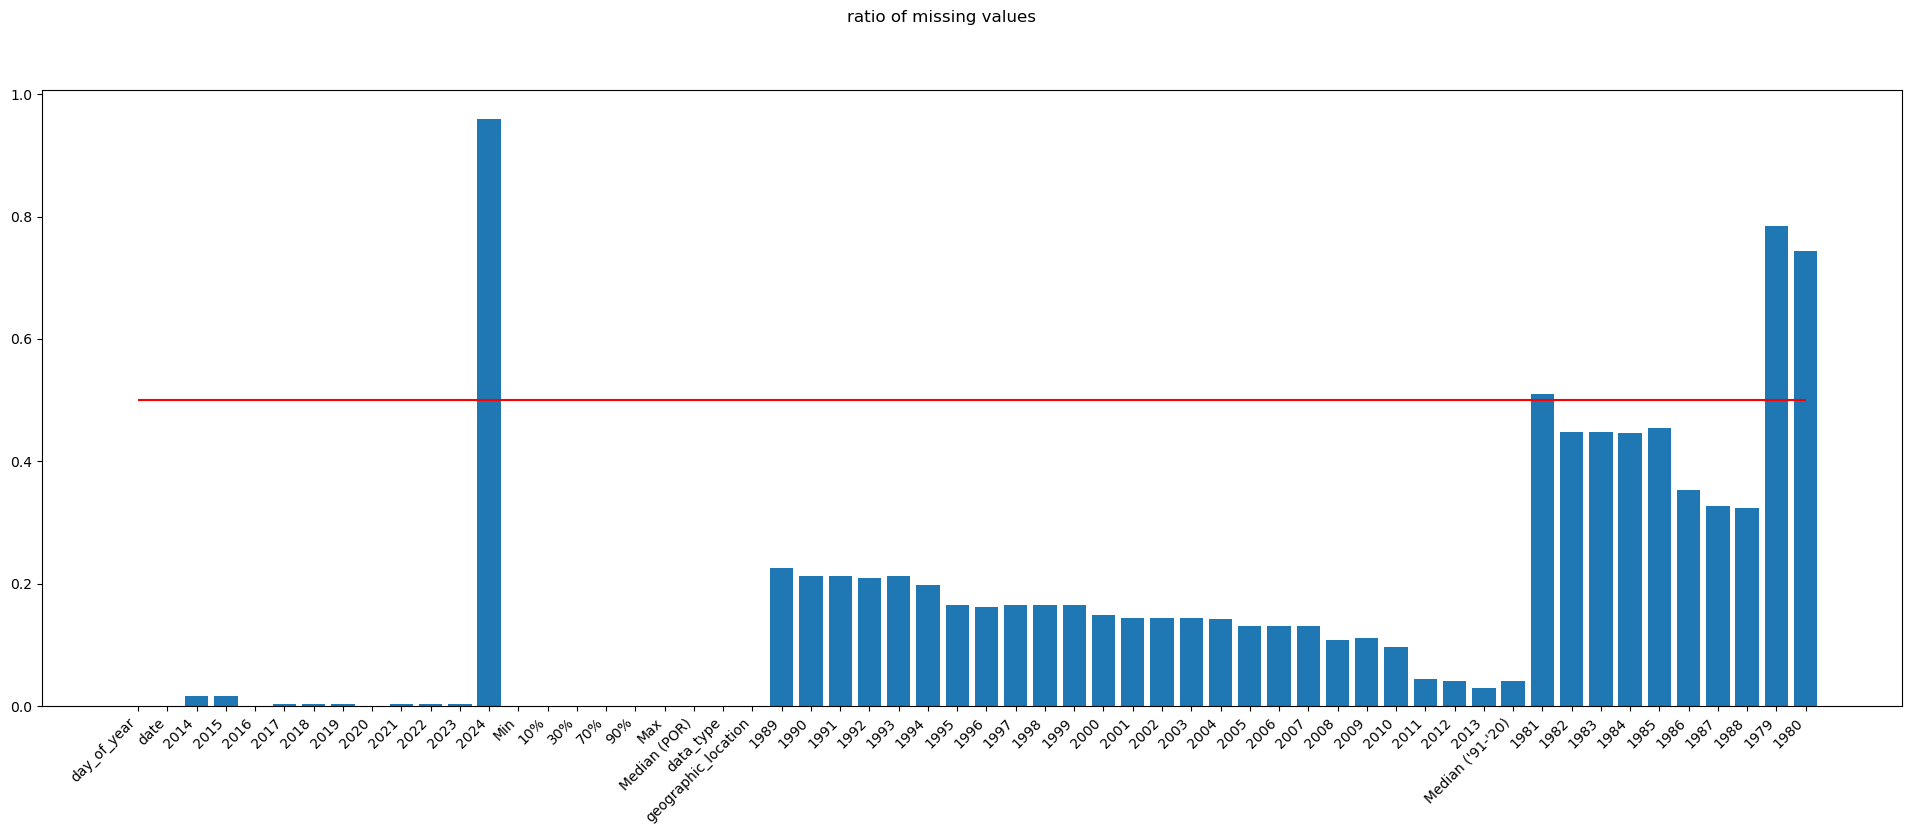

In [14]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (24, 8))
fig.suptitle("ratio of missing values")
ax.bar(df_nan["column_name"], df_nan["nan_ratio"])
plt.xticks(rotation = 45, ha = 'right');
ax.hlines(y = 0.5,  xmin = ax.get_xticks()[0], xmax = ax.get_xticks()[len(ax.get_xticks()) - 1], color = 'r')

#### The columns corresponding to 1981, 1980, and 1979 are missing more that 50% of their values. The column for 2024 is also mostly missing but this data is junk anyway.

#### I will drop the above columns as well as the columns that correspond to aggregate statistics, like median and mean, since the information they represent is included in the rest of the data.

In [15]:
df_full.drop(['1981', 'Min', '10%', '30%', '70%', '90%', 'Max', 'Median (\'91-\'20)', 'Median (POR)', '1979', '1980'], axis = 1, inplace = True) 

In [16]:
df_full.head(5)

,day_of_year,date,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,data_type,geographic_location,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,1982,1983,1984,1985,1986,1987,1988
0,0,10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,swe,deep_creek_mountains,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,10-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,swe,deep_creek_mountains,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,10-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,swe,deep_creek_mountains,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,10-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,swe,deep_creek_mountains,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,10-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,swe,deep_creek_mountains,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3 Initial Plots

#### Now that the initial data set is created, I create two plots. The first plot will show the mean SWE per month with error bars over all of the years of data. The second plot will the the same but for precipitation data.

In [17]:
# I am selecting the swe data and assigning it to this data frame.
df_swe_agg = df_full.loc[df_full['data_type'] == 'swe', ['day_of_year', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']].groupby('day_of_year').mean()

# I reformat df_swe_agg into a dataframe that will be more conveneint to plot with.
df_swe_plot = pd.DataFrame(index = df_swe_agg.index, columns = ['mean', 'std'])
for index, row in df_swe_plot.iterrows():
    df_swe_plot.loc[index, 'mean'] = df_swe_agg.loc[index, :].mean()
    df_swe_plot.loc[index, 'std'] = df_swe_agg.loc[index, :].std()

#### The SWE plot below shows three important things. First it shows how the SWE increases until the end of spring and then declines rapidly as the snow melts. Secondly, it shows the natural variabtion of the SWE at a given date and how higher peak SWE values occur later in the year than do lower peak SWE values. Finally, because the standard deviation is plotted symmetcially about the mean, some of the error bounds dip below zero; but this is just a plottic artifact. The distribution for SWE is bounded below by zero and so is highly asymmetric. A plotting function that took this into acount would not show this artifact. 

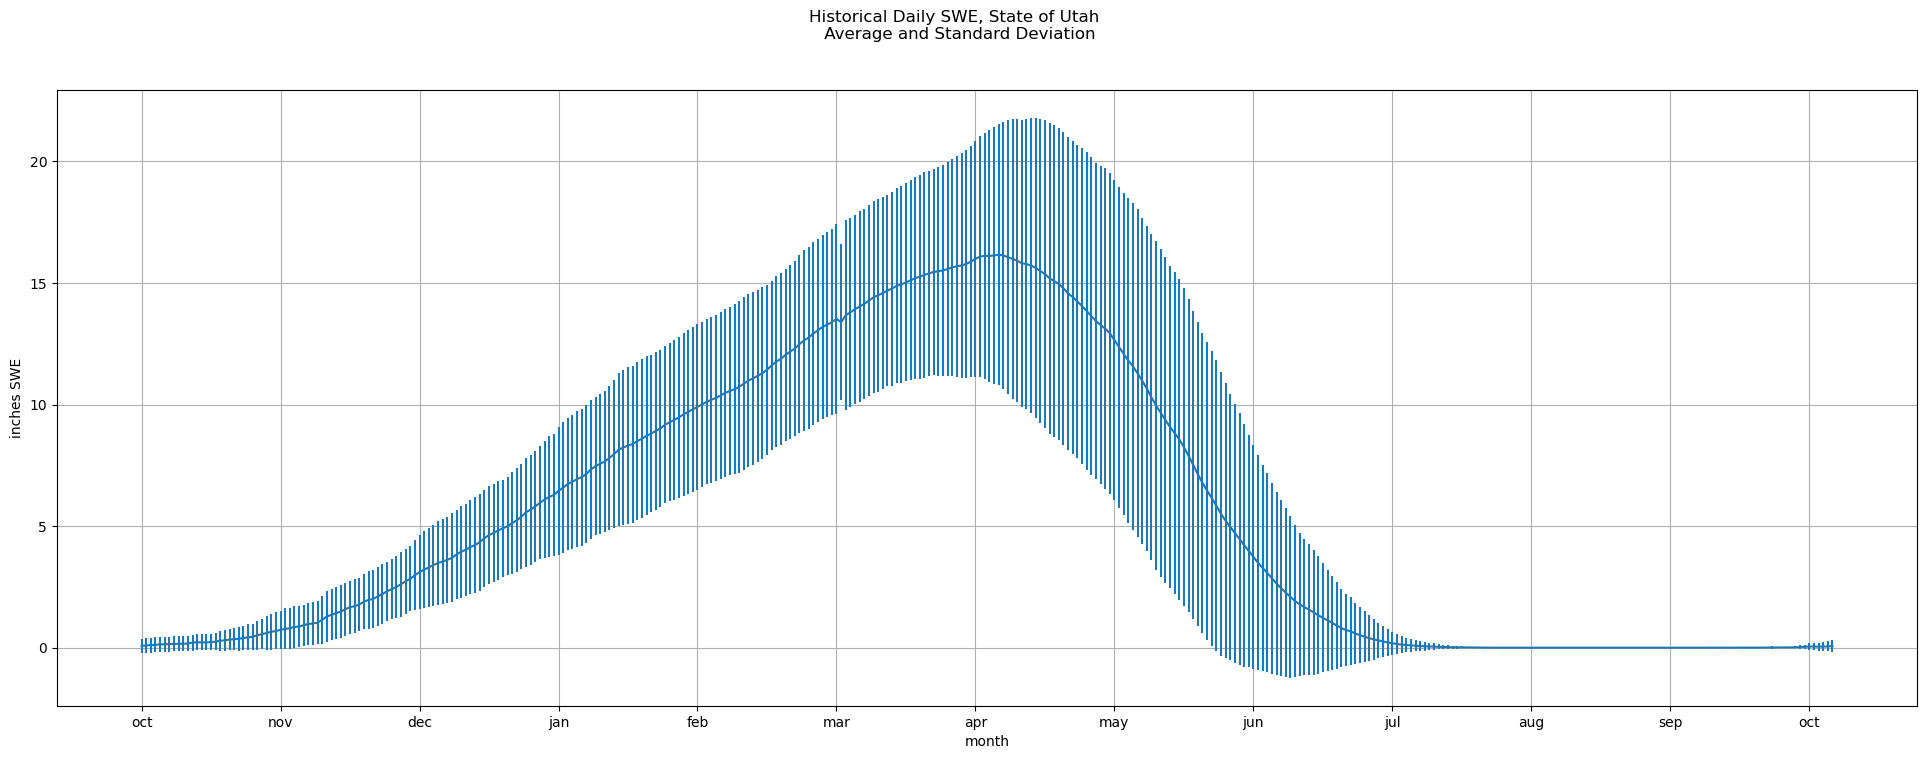

In [18]:
fig1, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (24, 8))
fig1.suptitle("Historical Daily SWE, State of Utah \n Average and Standard Deviation")
ax1.errorbar(df_swe_plot.index, df_swe_plot['mean'], yerr = df_swe_plot['std'])
ax1.set_xticks(list(range(0, 365, 30)))
ax1.set_xticklabels(['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct'])
ax1.set_xlabel("month");
ax1.set_ylabel("inches SWE");
plt.grid(which = 'both')

In [19]:
df_precip_agg = df_full.loc[df_full['data_type'] == 'precip', ['day_of_year', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']].groupby('day_of_year').mean()

df_precip_plot = pd.DataFrame(index = df_precip_agg.index, columns = ['mean', 'std'])
for index, row in df_precip_plot.iterrows():
    df_precip_plot.loc[index, 'mean'] = df_precip_agg.loc[index, :].mean()
    df_precip_plot.loc[index, 'std'] = df_precip_agg.loc[index, :].std()

#### The cumulative precipitation plot below shows three main features. Firsty, it shows the average amount one can expect the cumulative precipitation to increase over the year. Secondly, it shows how the variance of the precipitation increases as the year progresses. Thirdly, it shows that june through mid july are the dryest months of the year, with the slope of the average cumulative precipitation leveling off close to zero within that time frame.

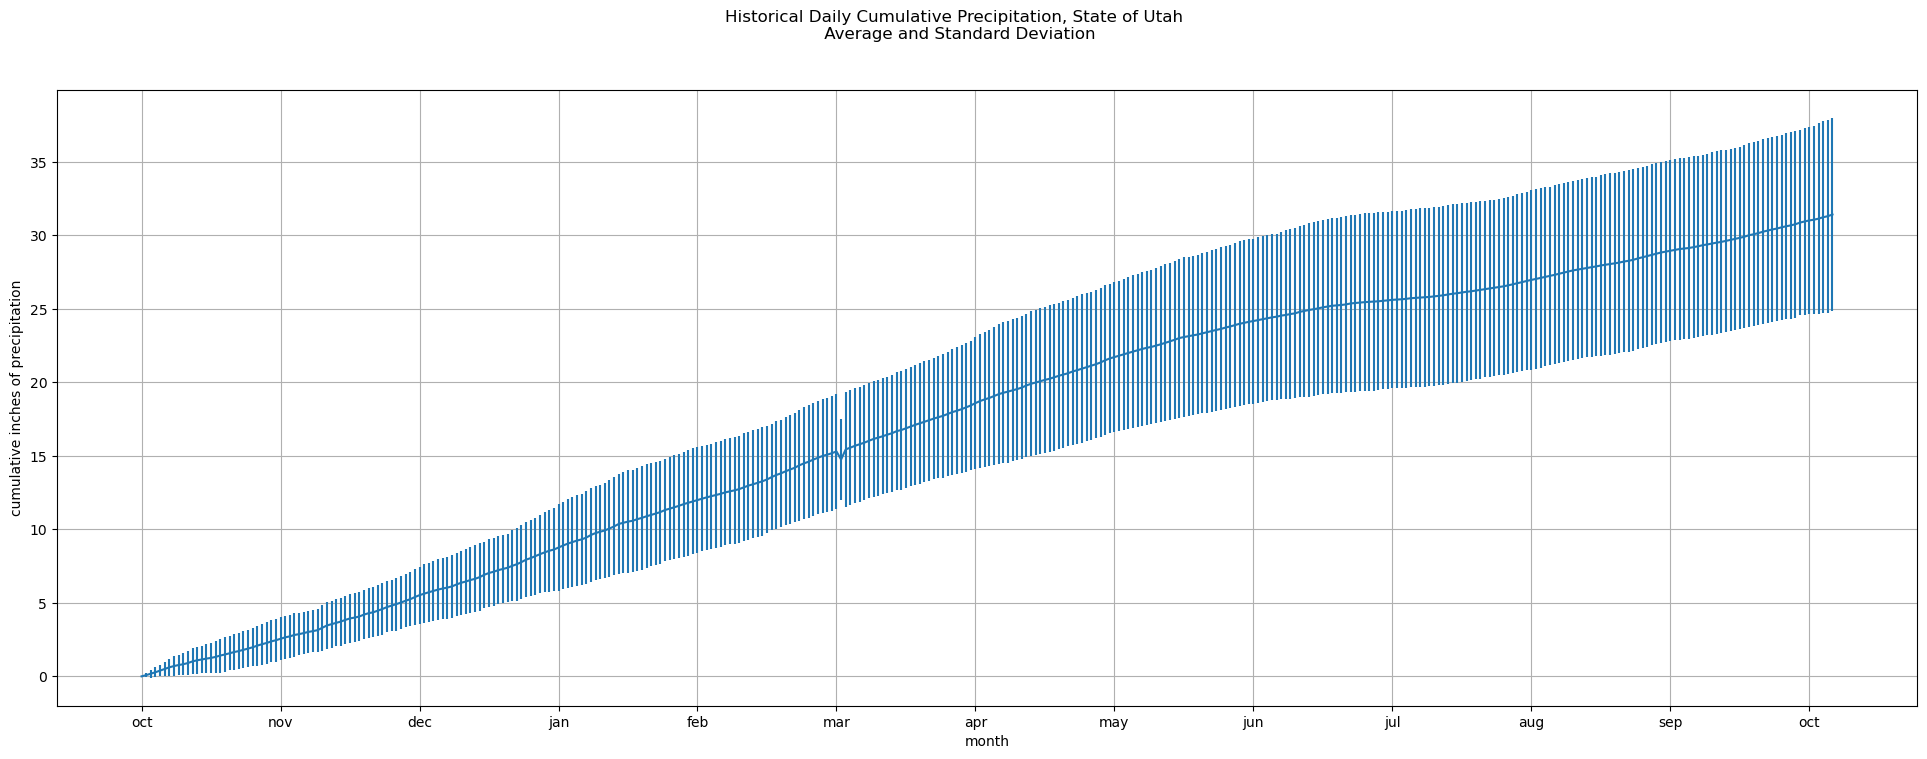

In [20]:
fig2, ax2 = plt.subplots(nrows = 1, ncols = 1, figsize = (24, 8));
fig2.suptitle("Historical Daily Cumulative Precipitation, State of Utah \n Average and Standard Deviation")
ax2.errorbar(x = df_precip_plot.index, y = df_precip_plot['mean'], yerr = df_precip_plot['std'])
ax2.set_xticks(list(range(0,365,30)));
ax2.set_xticklabels(['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct'])
ax2.set_xlabel("month")
ax2.set_ylabel("cumulative inches of precipitation")
ax2.grid()

### 1.4 Imputing Missing Values

#### Now that I have a visual handle on the data, I will deal with the missing values. I have dropped all of the columns that are missing more than 50% of their values. What I still need to do is impute the missing values for the remaining columns.

#### My strategy for imputation will be to replace missing values by randomly selecting values from the existing data from the same day and month in the year. So if a value is missing for Oct 8th, 1985 then I will randomly draw a value from all of the existing data points for Oct 8th. I will do this for each missing data point with replacement.

#### My reason to adopting this strategy is that it will maintain the average value of SWE or precipitation among the imputed values and also inform the predictive model of the variance of the real data when it is fitting to the imputed data.

In [21]:
import numpy as np
from numpy.random import choice

def sample_with_replacement(x : np.array) -> float:
    return choice(x);

def isNan(num):
    return num != num

#### The block below creates a dictionary with the necessary rows of imputed values sampled with replacement from data within the same datetime.

#### The idea with this subroutine is to identify the nan values within each row and then store a list of randomly selected values, on for each nan value, chosen from the non-nan values from the same row.

#### The cell immediately below is responsible for selecting the random values for each row.

In [22]:
imputation_dictionary = {}
for index, row in df_full[['1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']].iterrows():
    imputed_vec = [];
    non_nan_values = [i for i in row if not isNan(i)]
    for j in row:
        if isNan(j):
            imputed_vec.append(sample_with_replacement(non_nan_values));
         
    imputation_dictionary.update({index : imputed_vec});

#### The cell immediately below inserts the randomly selected values frome each row into the empty cells in df_full into the same rows.

In [23]:
for index, row in df_full.iterrows():
    for row_index, row_value in enumerate(row):
        if isNan(row_value):
            df_full.loc[index, row.index[row_index]] = imputation_dictionary[index][0]
            imputation_dictionary[index].pop(0);

In [24]:
df_full.head(5)

,day_of_year,date,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,data_type,geographic_location,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,1982,1983,1984,1985,1986,1987,1988
0,0,10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,swe,deep_creek_mountains,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,10-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,swe,deep_creek_mountains,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.3,0.0,0.0
2,2,10-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,swe,deep_creek_mountains,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.0
3,3,10-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,swe,deep_creek_mountains,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0
4,4,10-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,swe,deep_creek_mountains,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### I will get rid of day_of_year now because the next steps will be to format the data sequentially by date.

In [25]:
df_full.drop('day_of_year', axis = 1, inplace = True)

### 1.4 Date Formatting

#### Now that the imputation using selection with replacement is done I will do format the data with respect to date. I'll begin by adding a column that lists a full date with the format YYYY-mm-dd

In [34]:
df_full.columns

Index(['date', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021',
       '2022', '2023', '2024', 'data_type', 'geographic_location', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '1982', '1983', '1984',
       '1985', '1986', '1987', '1988'],
      dtype='object')

#### I want the data to be formatted such that each row corresponds to a year. So I will create a list of all of the years which I will use to this end.

In [35]:
def isYear(inputString):
    date_list = ['1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']
    if inputString in date_list:
        return True;
    else:
        return False;

#### This block, below, created a dictionary from df_full that will then be cast into a dataframe with the correct format. It inadvertently creates some impossible dates, however they will be removed in the step where I convert the dates trings to the datetime format.

#### Each column that I need in the final formatted data is represented by keys in the dictionary time_series_dict.

In [36]:
time_series_dict = {'full_date' : [], 'data_type' : [], 'geographic_location' : [], 'value' : []}
for index, row in df_full.iterrows():
    for row_index, value in row.items():
        if isYear(row_index):
            time_series_dict['full_date'].append(row_index + '-' + row['date']);
            time_series_dict['data_type'].append(row['data_type']);
            time_series_dict['geographic_location'].append(row['geographic_location']);
            time_series_dict['value'].append(value)

#### Now the dictionary is cast as a data frame and the index is set to full date.

In [37]:
df_time_series = pd.DataFrame(time_series_dict).set_index('full_date', drop = True)

#### Now the data are formatted with with a grain of date, datatype, geographic_location, and value

In [38]:
df_time_series.head()

,data_type,geographic_location,value
full_date,,,
2014-10-01,swe,deep_creek_mountains,0.0
2015-10-01,swe,deep_creek_mountains,0.0
2016-10-01,swe,deep_creek_mountains,0.0
2017-10-01,swe,deep_creek_mountains,0.0
2018-10-01,swe,deep_creek_mountains,0.0


#### I will split the full time series data set into different data sets for swe and precipitation...

In [39]:
df_time_series_swe = df_time_series[df_time_series['data_type'] == 'swe'].reset_index()

In [40]:
df_time_series_swe.rename(columns = {"value" : "swe"}, inplace = True)

#### ... And now for the precipitation.

In [41]:
df_time_series_precip = df_time_series[df_time_series['data_type'] == 'precip'].reset_index()

In [42]:
df_time_series_precip.rename(columns = {"value" : "precip"}, inplace = True)

#### Now I can concatenate these two dataframes along axis 1 to recreate a full data set that is closer to being useful in the context of training a model.

In [43]:
df_time_series_final = pd.concat([df_time_series_swe[['full_date', 'geographic_location', 'swe']],
                                  df_time_series_precip[['precip']]], axis = 1, ignore_index = False)

#### With the new dataframe it is time to cast the dates, in string format, to python's datetime format. Imposibble dates are identified as throwing an exception when input into date.parse. When that exception is thrown, I assign a date of 1900-01-01. The records with this date will be dropped in the next cell.

In [44]:
import dateutil.parser as date

def date_functional(date_string):
    try: 
        date_time = date.parse(date_string);
    except ValueError:
        # this date is used as a marker of an impossible date for later removal.
        date_time = date.parse('1900-01-01');

    return date_time;
        

df_time_series_final['full_date'] = df_time_series_final['full_date'].apply(lambda x : date_functional(x))

#### As mentioned above, impossible dates are removed here.

In [45]:
df_time_series_final.drop(
    df_time_series_final[df_time_series_final['full_date'] == date.parse('1900-01-01')].index, inplace = True)

In [46]:
df_time_series_final = df_time_series_final.sort_values(['full_date', 'geographic_location'], axis = 0).reset_index(drop = True)

In [49]:
df_time_series_final.to_csv('./SWE-data/time_series_final.csv', index = False)

### 2.0 Exploration

#### Now I have the data formatted correctly for time series analysis I will do a bit of exploration.

#### I will plot the values of swe and precipitaton over time.

In [50]:
import pandas as pd

# set max display columns and rows to a large number to facilitate initial exploration of data.
pd.options.display.max_rows = 1000;
pd.options.display.max_columns = 100;

In [51]:
df_time_series = pd.read_csv('./SWE-data/time_series_final.csv', low_memory = False)

In [52]:
df_time_series.columns

Index(['full_date', 'geographic_location', 'swe', 'precip'], dtype='object')

#### One thing that I notice in all of these plots is that there are, broadly speaking, cycles between wet and dry years that occur with a period of about ten years. 

#### One thing to note in the plots below is that the most recent two years (all the way to the right on these plots) looks very noisy. This is because it is totally imputed and just fictional. These data correspond to 2024 and 2025 and so are obviously vaccuous. I will remove these values before I train the model.

<Axes: title={'center': 'cottonwoord swe'}>

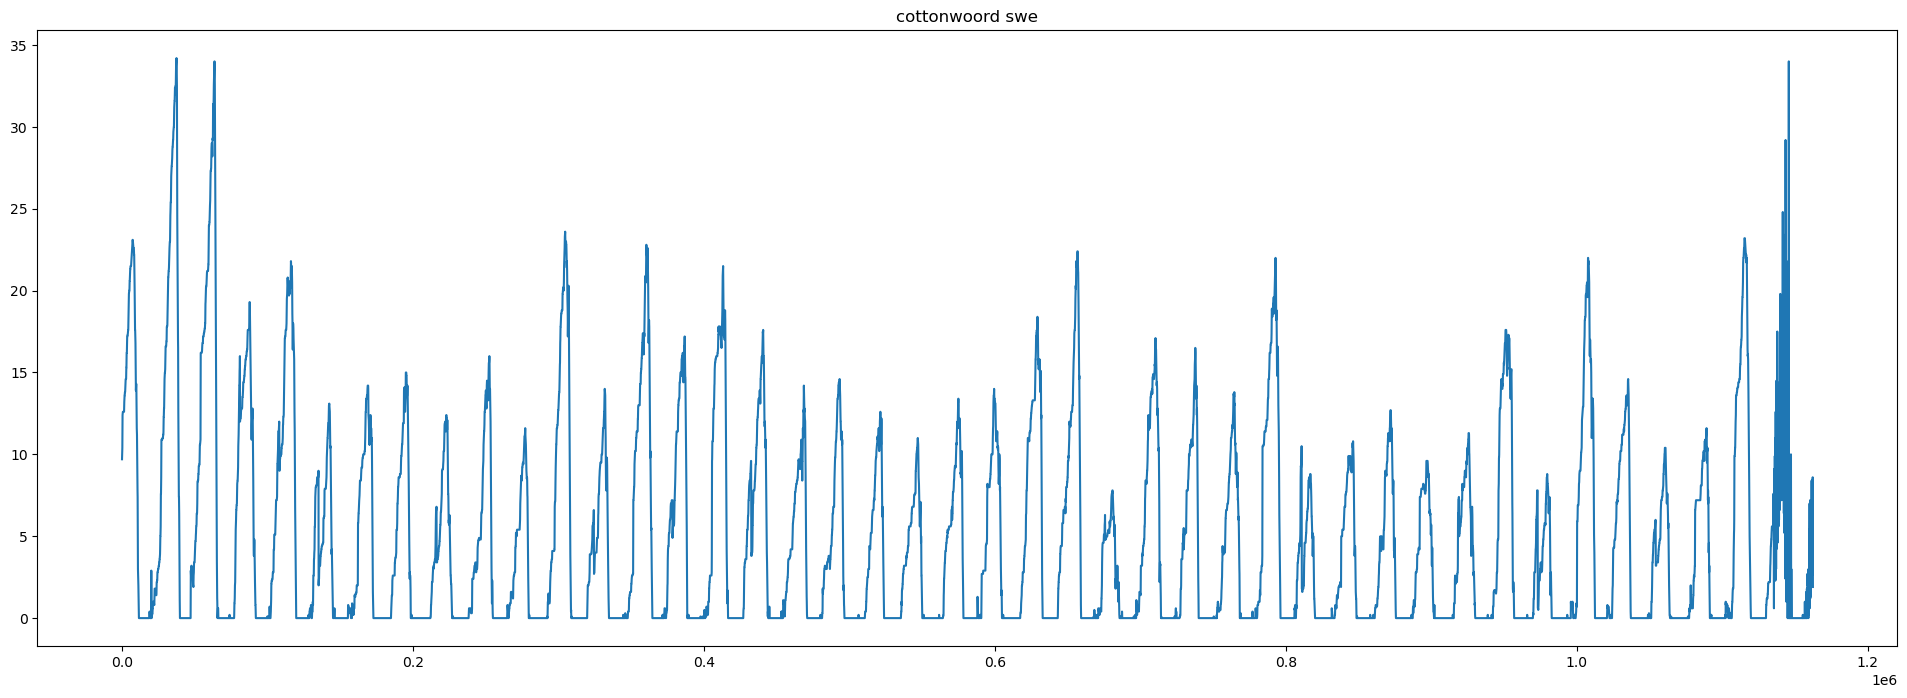

In [53]:
df_time_series.loc[df_time_series['geographic_location'] == 'cottonwood', 'swe'].plot(figsize = (24, 8), title = 'cottonwoord swe')

<Axes: title={'center': 'upper sevier swe'}>

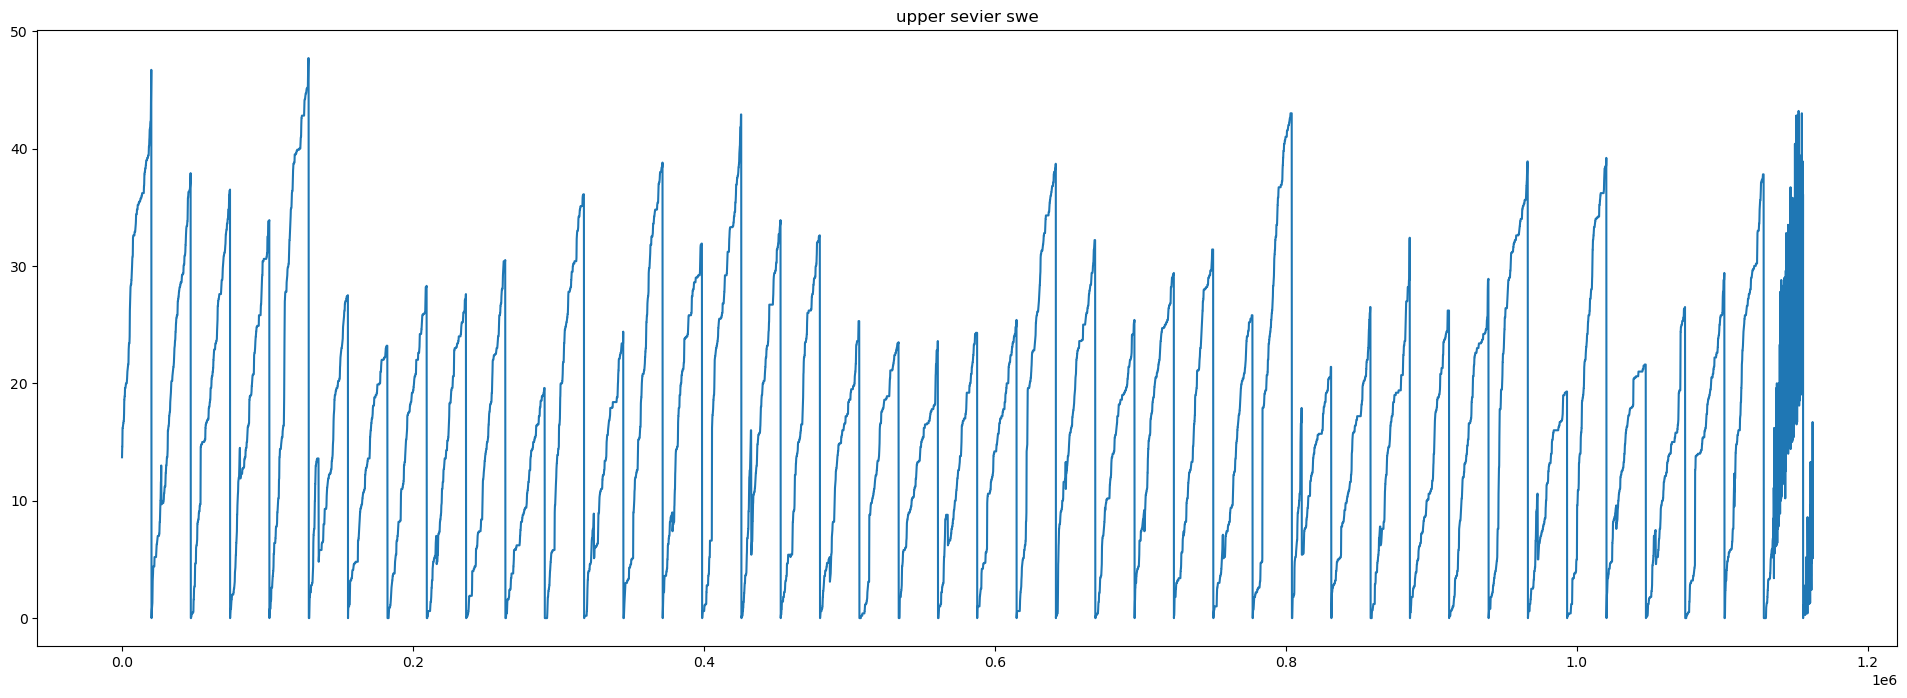

In [54]:
df_time_series.loc[df_time_series['geographic_location'] == 'upper_sevier', 'precip'].plot(figsize = (24, 8), title = 'upper sevier swe')

<Axes: title={'center': 'upper sevier swe'}>

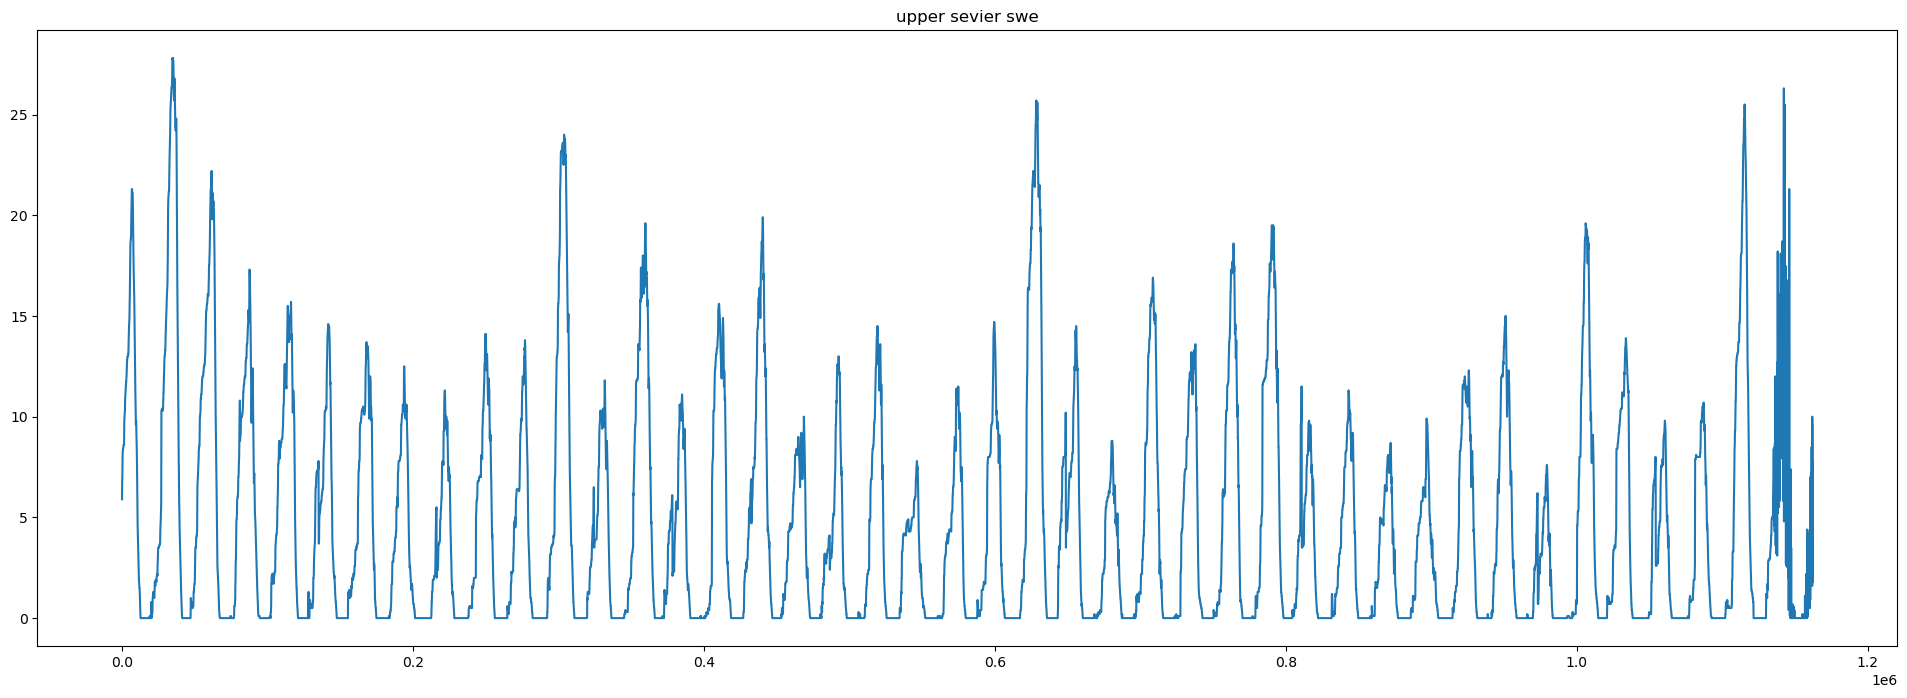

In [55]:
df_time_series.loc[df_time_series['geographic_location'] == 'upper_sevier', 'swe'].plot(figsize = (24, 8), title = 'upper sevier swe')

## 3.0 Modeling

#### Now I will begin building the predictive model using an LSTM RNN.

In [59]:
df_time_series = pd.read_csv('./SWE-data/time_series_final.csv', low_memory = False)

#### I will be using Tensorflow and Keras to build an LSTM model for SWE.

#### For more information see here: https://keras.io/examples/timeseries/timeseries_weather_forecasting/

In [60]:
df_time_series.head(10)

,full_date,geographic_location,swe,precip
0,1982-01-01,american_fork,8.4,16.4
1,1982-01-01,ashley,5.2,9.2
2,1982-01-01,bear,12.4,16.7
3,1982-01-01,bear_lake,12.5,10.0
4,1982-01-01,beaver,7.2,15.4
5,1982-01-01,big_cottonwood,6.8,18.9
6,1982-01-01,bingham,7.6,10.3
7,1982-01-01,blacks_fork,4.4,6.4
8,1982-01-01,blacksmith_fork,14.4,6.6
9,1982-01-01,chalk,13.0,15.5


### 3.1 Initial Feature Engineering

#### I will expand the nubmer of features such that geographic location will be paired with its respective swe, precip, lat, lon.

#### My plan after that is to use all of the geographic locations to train a model to predict the swe for one geographic location of interest. In this way a separate model can be trained to predict each geographic location.

#### For now, I will use all of the locations to predict the snow pack in big_cottonwood seven days into the future using 30 days of data from the past.

In [65]:
df_time_series_engineered = pd.DataFrame(columns = ['full_date'], data = df_time_series['full_date'].unique()).set_index('full_date')

In [66]:
for location in list(df_time_series['geographic_location'].unique()):
    sub_df = df_time_series[df_time_series['geographic_location'] == location].set_index('full_date', drop = True);
    sub_df = sub_df[['geographic_location', 'swe', 'precip']].rename(columns = {'geographic_location' : location,
                             'swe' : 'swe' + '_' + location,
                             'precip' : 'precip' + '_' + location});
    sub_df = sub_df.drop([location], axis = 1);
    df_time_series_engineered = pd.concat([df_time_series_engineered, sub_df], axis = 1)

#### After the expansion there are 148 features in the data set.

In [67]:
df_time_series_engineered.head(5)

,swe_american_fork,precip_american_fork,swe_ashley,precip_ashley,swe_bear,precip_bear,swe_bear_lake,precip_bear_lake,swe_beaver,precip_beaver,swe_big_cottonwood,precip_big_cottonwood,swe_bingham,precip_bingham,swe_blacks_fork,precip_blacks_fork,swe_blacksmith_fork,precip_blacksmith_fork,swe_chalk,precip_chalk,swe_city,precip_city,swe_coal-parowan,precip_coal-parowan,swe_cottonwood,precip_cottonwood,swe_cub,precip_cub,swe_deep_creek_mountains,precip_deep_creek_mountains,swe_dirty_devil,precip_dirty_devil,swe_duchesne,precip_duchesne,swe_east_canyon,precip_east_canyon,swe_east_fork_sevier,precip_east_fork_sevier,swe_emigration,precip_emigration,swe_emigration(1),precip_emigration(1),swe_ephraim,precip_ephraim,swe_escalante,precip_escalante,swe_escalante-paria,precip_escalante-paria,swe_farmington,precip_farmington,...,swe_provo-utah_lake-jordan,precip_provo-utah_lake-jordan,swe_raft,precip_raft,swe_raft_mountains,precip_raft_mountains,swe_rock,precip_rock,swe_rush-tooele_valleys,precip_rush-tooele_valleys,swe_san_pitch,precip_san_pitch,swe_santa_clara,precip_santa_clara,swe_sevier_headwaters,precip_sevier_headwaters,swe_sheep,precip_sheep,swe_smiths_fork,precip_smiths_fork,swe_southeastern_utah,precip_southeastern_utah,swe_southwestern_utah,precip_southwestern_utah,swe_spanish_fork,precip_spanish_fork,swe_state_of_utah,precip_state_of_utah,swe_strawberry,precip_strawberry,swe_tooele_valley-vernon_creek,precip_tooele_valley-vernon_creek,swe_twelvemile,precip_twelvemile,swe_uinta,precip_uinta,swe_upper_bear,precip_upper_bear,swe_upper_beaver,precip_upper_beaver,swe_upper_sevier,precip_upper_sevier,swe_upper_virgin,precip_upper_virgin,swe_weber-ogden,precip_weber-ogden,swe_willow,precip_willow,swe_yellowstone,precip_yellowstone
full_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1982-01-01,8.4,16.4,5.2,9.2,12.4,16.7,12.5,10.0,7.2,15.4,6.8,18.9,7.6,10.3,4.4,6.4,14.4,6.6,13.0,15.5,7.6,12.4,6.0,7.8,9.7,13.0,12.3,20.8,8.0,1.4,6.1,11.8,7.9,12.8,5.7,15.0,4.7,2.9,23.1,10.5,6.7,8.9,7.7,8.9,5.3,7.2,1.5,11.0,14.4,12.4,...,9.8,12.8,10.4,11.8,10.7,11.4,7.6,18.9,3.3,9.9,7.9,12.5,2.0,9.7,4.8,18.0,3.8,6.1,5.8,6.4,5.7,7.7,3.2,7.6,9.5,15.4,8.9,13.3,7.2,13.7,8.2,6.3,5.2,5.6,5.6,9.6,13.0,16.3,7.2,8.9,5.9,13.7,3.2,6.3,12.6,17.8,2.1,7.6,8.0,11.4
1982-01-02,12.6,17.6,5.6,9.7,12.8,17.2,12.8,10.2,8.0,15.6,16.4,12.0,2.4,10.1,7.8,7.2,14.8,6.7,13.4,15.9,4.6,9.3,7.0,8.8,10.0,13.2,13.0,23.3,4.3,6.6,6.4,12.0,8.6,13.5,11.7,14.2,4.7,8.0,7.1,26.8,8.6,9.7,8.2,9.4,2.5,4.8,4.9,11.6,8.7,13.6,...,10.7,13.3,10.4,12.0,5.0,9.4,8.4,11.5,9.6,11.0,8.5,13.2,7.6,4.8,5.8,7.0,3.9,6.4,4.2,5.8,3.8,8.9,4.1,8.5,10.2,15.9,9.5,14.0,8.2,14.7,5.4,4.8,5.2,6.6,5.8,9.8,13.5,16.9,8.0,9.7,6.7,14.3,4.1,7.1,13.2,18.4,1.9,7.2,8.2,11.4
1982-01-03,16.6,17.8,5.6,9.7,13.0,17.4,13.0,10.6,8.3,15.6,15.2,6.5,8.2,11.0,4.6,7.5,15.0,5.9,13.5,16.2,4.4,10.6,7.2,9.0,10.3,13.4,13.2,23.3,5.4,8.1,6.9,12.5,8.7,13.6,12.7,14.2,1.9,14.3,6.1,13.9,5.2,10.1,8.2,9.4,8.0,6.0,6.7,11.8,8.6,13.9,...,11.2,13.4,12.0,12.5,9.1,8.5,8.5,12.8,5.7,4.8,9.0,13.6,2.0,9.8,5.9,13.0,4.3,7.6,4.3,6.1,2.7,11.9,4.3,8.8,10.8,16.2,9.8,14.3,8.5,14.9,10.6,12.0,5.2,5.6,5.8,9.8,13.7,17.1,8.3,10.1,6.9,14.6,4.3,7.4,13.5,18.7,2.0,1.6,8.2,11.6
1982-01-04,20.0,17.9,5.6,9.7,13.0,17.6,13.4,10.7,8.3,15.9,7.4,8.0,4.8,8.8,5.4,7.5,15.2,6.0,13.6,16.3,6.8,6.2,7.2,9.0,10.4,13.6,13.7,24.0,0.9,9.1,7.1,12.9,8.8,13.8,4.8,14.2,6.7,4.9,5.1,15.0,7.5,10.2,8.3,9.5,5.6,5.0,0.2,11.8,10.0,14.5,...,11.3,13.7,6.2,12.9,8.9,12.2,8.6,6.2,8.2,6.9,9.2,13.8,6.4,6.7,5.9,8.9,3.0,8.7,6.4,6.2,4.0,5.8,4.3,8.8,10.8,16.5,9.8,14.4,8.6,15.0,8.2,12.8,5.2,5.6,5.8,10.0,13.7,17.2,8.3,10.2,7.0,14.6,4.3,7.4,13.7,19.0,8.6,9.2,8.6,12.0
1982-01-05,7.7,18.6,5.8,9.8,13.8,18.3,14.2,12.3,9.3,16.4,8.1,12.0,4.4,10.4,7.8,7.6,15.8,3.7,14.0,16.8,17.6,8.3,7.2,9.0,11.8,15.0,15.0,24.6,5.4,7.9,8.1,13.9,9.4,14.2,10.4,10.4,4.6,5.2,9.6,17.5,12.3,11.0,9.0,10.2,0.0,7.2,2.0,12.5,11.2,15.7,...,12.2,14.3,12.8,13.9,9.1,8.7,9.2,11.4,6.4,10.5,10.8,15.6,2.0,7.4,6.

#### At this point, if my goal was to predict over all snowpack for thestate, it would be appropriate to remove features that were highly correlated with others, to simplify the model. However because I want to predict the swe for individual basins, leaving correlated basins in is the better choice.

#### I will however throw out dates beyond September 30, 2023, which was the date the data were downloaded on.

In [68]:
df_time_series_engineered = df_time_series_engineered.loc[df_time_series_engineered.index <= '2023-07-30']

### 3.2 Splitting the data in to training, validation, and holdout sets.

#### The target data will be from the swe in big_cottonwood_canyon column.

In [69]:
df_target = pd.DataFrame(df_time_series_engineered['swe_big_cottonwood'])

#### I will select 75% of the data for model training; this will be used to directly fit the parameters of the model. This block of data will be the earliers cronologically.

#### I will selec 15% of the data to be used as a valdiation set. This will be used to select the best values for hyper parameters after the model trains on the training data. This block of data will occur directly after the training set, chronologically.

#### I will then use 10% of the data as a hold out set to test the final performance of the mode. This block of data will be the most recent block.

In [70]:
training_ratio = 0.75;
validation_ratio = 0.15;
holdout_ratio = .1;

#### I am assigning each of these blocks of data from df_time_series_engineered to their own feature and target dataframes, named according to the standard convetion of X_* and y_*

In [71]:
X_training_series = df_time_series_engineered.iloc[0:int(training_ratio * len(df_time_series_engineered))]
X_validation_series = df_time_series_engineered.iloc[int(training_ratio * len(df_time_series_engineered)): int(training_ratio * len(df_time_series_engineered)) + 
                                                                                                           int(validation_ratio * len(df_time_series_engineered))]
X_holdout_series = df_time_series_engineered.iloc[int(training_ratio * len(df_time_series_engineered)) +
                                                  int(validation_ratio * len(df_time_series_engineered)) : int(training_ratio * len(df_time_series_engineered)) + 
                                                                                                           int(validation_ratio * len(df_time_series_engineered)) + 
                                                                                                           int(holdout_ratio * len(df_time_series_engineered))]

y_training_series = df_target.iloc[0:int(training_ratio * len(df_target))]
y_validation_series = df_target.iloc[int(training_ratio * len(df_target)): int(training_ratio * len(df_target)) + 
                                                                           int(validation_ratio * len(df_target))]
y_holdout_series = df_target.iloc[int(training_ratio * len(df_target)) +
                                  int(validation_ratio * len(df_target)) : int(training_ratio * len(df_target)) + 
                                                                           int(validation_ratio * len(df_target)) + 
                                                                           int(holdout_ratio * len(df_target))]

### 3.3 Selecting the amount of time in the past to use for predictions at a certain time in the future

#### Now it is time to decide what the structure of the past a future intervals will look like in the model. I will have the model look back in time 30 days from a given day (including that given day) to predict the swe in big_cottonwood seven days beyond that day (not including that given day)

In [72]:
past_data_interval = 30;
future_prediction_interval = 7;

X_training_series = X_training_series.iloc[0:-(past_data_interval + future_prediction_interval+1):]
y_training_series = y_training_series.iloc[past_data_interval + future_prediction_interval:-1,:]
 
X_validation_series = X_validation_series.iloc[0:-(past_data_interval + future_prediction_interval+1):]
y_validation_series = y_validation_series.iloc[past_data_interval + future_prediction_interval:-1,:]

X_holdout_series = X_holdout_series.iloc[0:-(past_data_interval + future_prediction_interval+1):]
y_holdout_series = y_holdout_series.iloc[past_data_interval + future_prediction_interval:-1,:]

holdout_dates = X_holdout_series.index;

#### With that time periods selected I will normalize the data by subtracting the mean and dividing by the standard deviation. I will write a function to do this.

In [73]:
def normalize_data(df):
    df_copy = df.copy()
    for column, item in df_copy.items():
        mean_temp = item.mean();
        std_temp = item.std();
        
        df_copy[column] = (df_copy[column] - mean_temp)/std_temp;
        
    return df_copy

In [74]:
X_training_series = normalize_data(X_training_series)
X_validation_series = normalize_data(X_validation_series)
X_holdout_series = normalize_data(X_holdout_series)

### 3.4 Setting up the model

#### In order to use all of the data I have thus far been working with I will use keras.utils to transform them into a Keras, "Dataset" object using keras.utils.timeseries_dataset_from_array. This will make coding the training, validation, and testing much easier and faster.

In [ ]:
batch_size = 2;

training_Dataset = tfk.preprocessing.timeseries_dataset_from_array(
    X_training_series,
    y_training_series,
    sequence_length=past_data_interval,
    sampling_rate=1,
    batch_size=batch_size,
 )
 
validation_Dataset = tfk.preprocessing.timeseries_dataset_from_array(
    X_validation_series,
    y_validation_series,
    sequence_length=past_data_interval,
    sampling_rate=1,
    batch_size=batch_size,
 )
 
holdout_Dataset = tfk.preprocessing.timeseries_dataset_from_array(
    X_holdout_series,
    y_holdout_series,
    sequence_length=past_data_interval,
    sampling_rate=1,
    batch_size=batch_size,
)

# a batch size greater than one decreases the number of data points by a factor of that number. I am selecting only those 
# dates from holdout_dates for which the mod of the index and the batch size is zero.
batched_holdout_dates = [holdout_dates[i] for i in range(len(holdout_dates)) if i%batch_size == 0]

for batch in training_Dataset.take(1):
     inputs, targets = batch
 
     print("Input shape:", inputs.numpy().shape)
     print("Target shape:", targets.numpy().shape)

#### The model will consist of an LSTM neural net with: an input layer with enough elements to accomondate, "inputs" tensor, 16 LSTM elements, followed by a dense layer.

In [ ]:
inputs = tfk.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_output = tfk.layers.LSTM(16)(inputs)
outputs = tfk.layers.Dense(1)(lstm_output)

model = tfk.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tfk.optimizers.Adam(learning_rate=.001), loss="mse")
model.summary()

#### Here I will define a callback that will stop fitting after 10 epochs if the validation loss does not improve. 

#### I will also define a callback to hold the intermediate values of the model as it trains.

In [87]:
path_checkpoint = "model_checkpoint.h5"
es_callback = tfk.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

modelckpt_callback = tfk.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

#### The model.fit() function of the Keras model, takes both training data as well as validation. This allows the algorithm to automatically tune the model's hyperparameters across the number of epochs that I have told the model to fit to.

In [88]:
history = model.fit(
     training_Dataset,
     epochs=20,
     validation_data=validation_Dataset,
     callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/20
5661/5661 [==============================] - ETA: 0s - loss: 7.3797
Epoch 1: val_loss improved from inf to 10.29126, saving model to model_checkpoint.h5
5661/5661 [==============================] - 77s 14ms/step - loss: 7.3797 - val_loss: 10.2913
Epoch 2/20
5657/5661 [============================>.] - ETA: 0s - loss: 7.7850
Epoch 2: val_loss did not improve from 10.29126
5661/5661 [==============================] - 77s 14ms/step - loss: 7.7810 - val_loss: 12.3738
Epoch 3/20
5660/5661 [============================>.] - ETA: 0s - loss: 7.2263
Epoch 3: val_loss did not improve from 10.29126
5661/5661 [==============================] - 70s 12ms/step - loss: 7.2250 - val_loss: 11.8761
Epoch 4/20
5658/5661 [============================>.] - ETA: 0s - loss: 7.3243
Epoch 4: val_loss improved from 10.29126 to 8.02032, saving model to model_checkpoint.h5
5661/5661 [==============================] - 71s 12ms/step - loss: 7.3212 - val_loss: 8.0203
Epoch 5/20
5657/5661 [=================

#### This block pulls out the actual SWE holdout values (y_holdout) and also makes predictions from the holdout data set features and stores them in y_predictions. I will use these lists to make a dataframe to compare the predicted values to the actual data in a plot below.

In [ ]:
y_holdout = []
y_predictions = []

for x, y in holdout_Dataset:
    inputs, targets = batch;
    y_holdout.append(y[0][0].numpy());
    y_predictions.append(model.predict(x)[0][0]);

In [89]:
# the LSTM sometimes predicts values below zero which are not physical, I am  removing them so that they do not incorrectly affect the prediction error.
y_predictions = [i if i >= 0.0 else 0.0 for i in y_predictions]

df_seven_day_predictions = pd.DataFrame(
    {"Actual SWE Data" : y_holdout,
    "Predicted SWE Values" : y_predictions},
    index = batched_holdout_dates[0:len(y_holdout)]
)

#### I am going to save the model and the df_seven_day_predictions data set so that I do not have to retrain the model if I want to manipulate them in the future.

In [91]:
joblib.dump(model, "./7_day_model.pickle");
joblib.dump(df_seven_day_predictions, "7_day_predictions_df.pickle");

### 4.0 Plotting

#### Below is a plot of the predicted values of SWE plotted on top of the actual data for SWE in big cottonwood. The predictions are made 7 days in the future from a givne date using 30 days of data from the past.

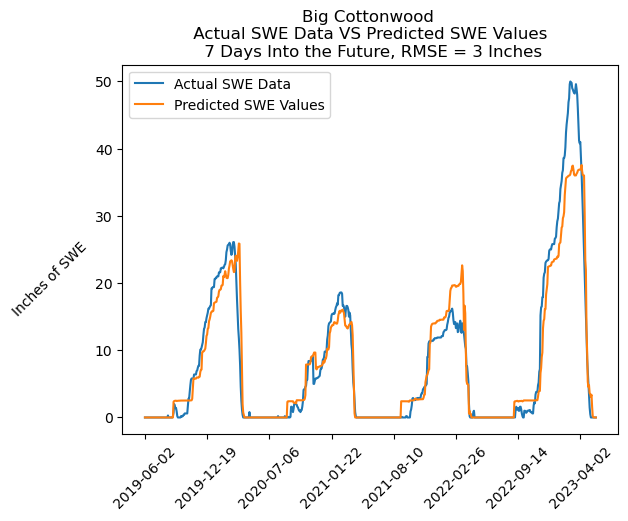

In [90]:
df_seven_day_predictions.plot(y = ["Actual SWE Data", "Predicted SWE Values"])

SWE_RMSE = np.sqrt((1/len(df_seven_day_predictions))*(
    (df_seven_day_predictions['Actual SWE Data'] - df_seven_day_predictions['Predicted SWE Values'])**2
).sum())

plt.xticks(rotation = 45);
plt.ylabel('Inches of SWE', rotation = 45,horizontalalignment = 'right')
plt.title('Big Cottonwood \n Actual SWE Data VS Predicted SWE Values \n 7 Days Into the Future, RMSE = {} Inches'.format(round(SWE_RMSE)));

### 5.0 Future work

#### There are several next steps for this work. 
##### 1. I would add an additional bias layer to the neural net, after the LSTM layer, that could encorporate the geographic location in the form of GPS coordinates. This might help improve accuracy because more southerly locations would correlate more explicitly with lower SWE and precipitation. 

##### 2. Another step could be to experiment with the number of LSTM elements.

##### 4. Next even better predictions may be possible made using more granular data from each individual data collection site, instead of basins like I'm using now. Of course, using every individual collection station might make the dimension of the problem too large.

##### 5. Finally, it would be useful to add a layer to the model that would take each prediction that was made and compare it to the actual value of SWE after seven days. The difference of these to values in this model could be used to regress a correction added to the LSTM prediction to increase its accuracty. Taken together this stacked model would be a quasi-reinforcement learning model.